Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [2]:
#Load the dataset
data = pd.read_csv('/datasets/car_data.csv')

In [3]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [4]:
# Data Exploration
print(data.head())

        DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  24/03/2016 11:52    480         NaN              1993  manual      0   
1  24/03/2016 10:58  18300       coupe              2011  manual    190   
2  14/03/2016 12:52   9800         suv              2004    auto    163   
3  17/03/2016 16:54   1500       small              2001  manual     75   
4  31/03/2016 17:25   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3   golf   150000                  6    petrol  volkswagen          no   
4  fabia    90000                  7  gasoline       skoda          no   

        DateCreated  NumberOfPictures  PostalCode          LastSeen  
0  24/03/2016 00:00               

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
print(data.describe())

               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

In [7]:
# Check for duplicates
print(data.duplicated().sum())

262


In [8]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Check again for duplicates
print(data.duplicated().sum())

0


In [9]:
#Check for missing values
print(data.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37484
RegistrationYear         0
Gearbox              19830
Power                    0
Model                19701
Mileage                  0
RegistrationMonth        0
FuelType             32889
Brand                    0
NotRepaired          71145
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [10]:
# Handle missing values
data.dropna(inplace=True)

#check again for missing values
print(data.isna().sum())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


# Data Visualization

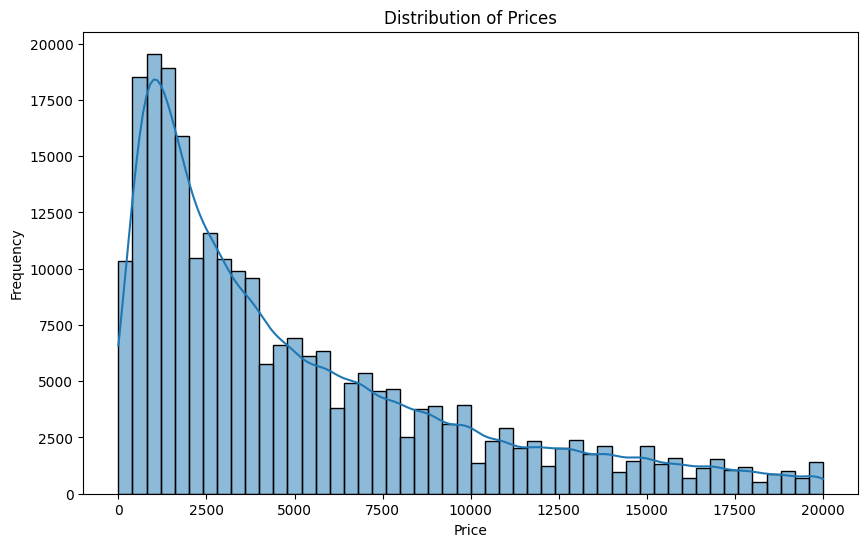

In [11]:
# Distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

This histogram displays the distribution of car prices in the dataset.
Interpretation:
The majority of car prices are clustered around the lower end of the price range, with a steep drop-off as the price increases.
There are many cars priced below 5,000, and the frequency significantly decreases for higher prices.
The distribution is right-skewed, meaning there are fewer cars at the higher price ranges.


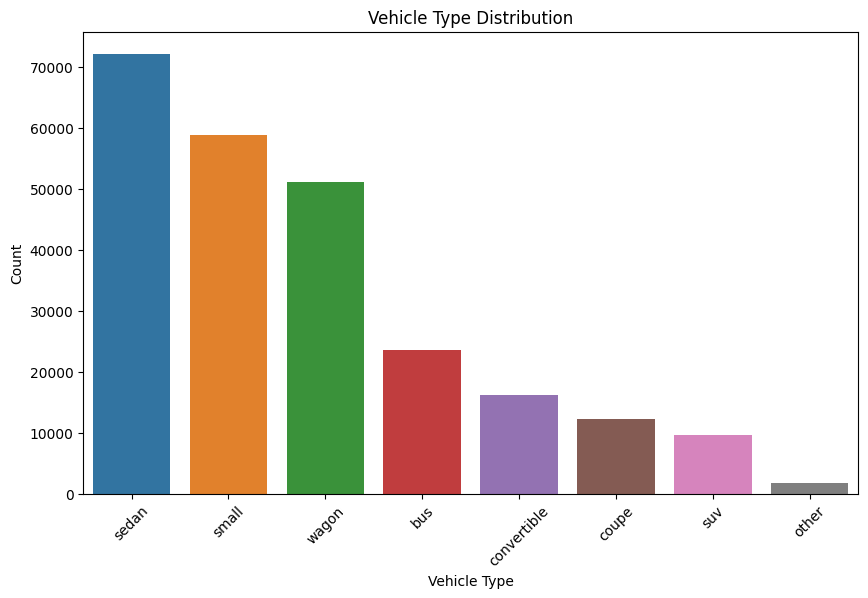

In [12]:
# Vehicle type counts
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='VehicleType', order=data['VehicleType'].value_counts().index)
plt.title('Vehicle Type Distribution')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

This bar chart shows the count of different vehicle types in the dataset.
Interpretation:
Sedans are the most common vehicle type, followed by small cars and wagons.
SUVs, convertibles, and coupes are less common.
The "other" category has the fewest entries, indicating rare or less common vehicle types.


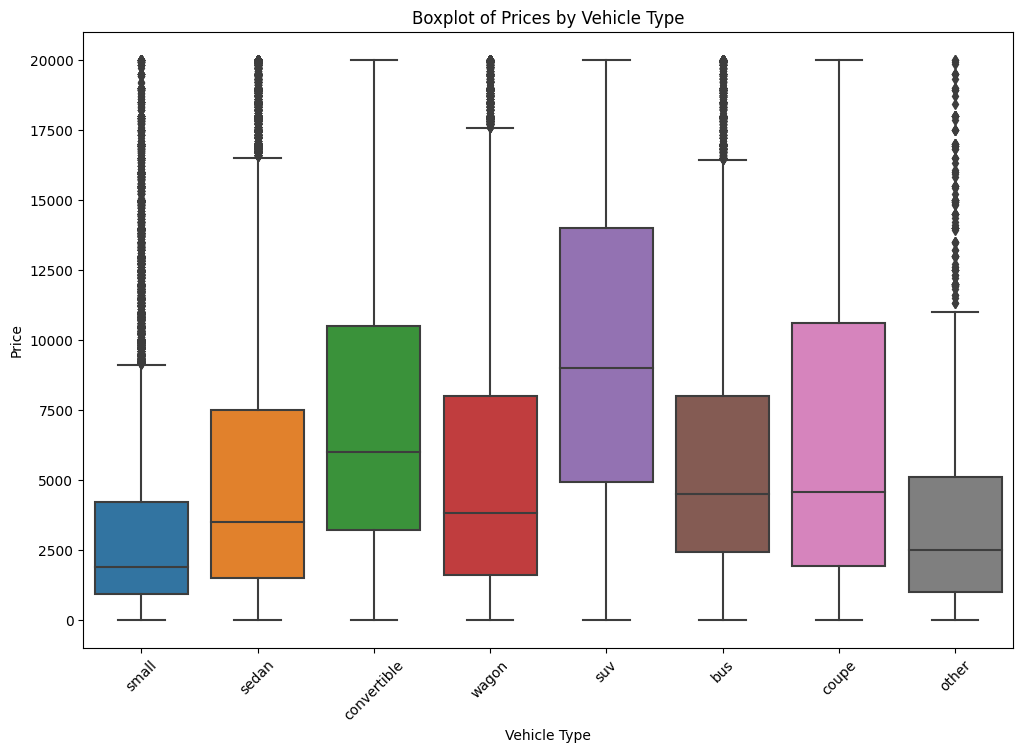

In [13]:
# Boxplot of prices by vehicle type
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='VehicleType', y='Price')
plt.title('Boxplot of Prices by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

This boxplot illustrates the distribution of car prices across different vehicle types.
Interpretation:
Each boxplot shows the median (central line), interquartile range (box), and potential outliers (points outside the whiskers).
Convertibles and coupes generally have higher price medians and larger price ranges compared to other vehicle types.
Small cars and buses have lower price medians.
There is a significant spread in prices within each vehicle type, with noticeable outliers, especially for convertibles and SUVs.

## Model training

#Step 1: Preprocess the Data

In [15]:
# Selecting features and target
X = data.drop(columns=['Price'])
y = data['Price']

In [16]:
# List of categorical columns
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [17]:
# List of numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [18]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [19]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Step 2: Train Different Models

In [20]:
#Linear Regression
# Pipeline for Linear Regression
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [21]:
#Decision Tree
# Pipeline for Decision Tree
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', DecisionTreeRegressor(random_state=42))])

# Train the model
dt_pipeline.fit(X_train, y_train)

# Predict
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

In [22]:
# Pipeline for XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb.XGBRegressor(random_state=42))])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [23]:
# CatBoost pipeline
cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', CatBoostRegressor(random_state=42, silent=True))])

# Train the model
cat_pipeline.fit(X_train, y_train)

# Predict
y_pred_cat = cat_pipeline.predict(X_test)

# Ensure the length of predictions matches the length of the test set
assert len(y_pred_cat) == len(y_test), "Mismatch in the number of predictions and actual values"

# Evaluate
mse_cat = mean_squared_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

In [24]:
print(f"Linear Regression - MSE: {mse_lr}, R2: {r2_lr}")
print(f"Decision Tree - MSE: {mse_dt}, R2: {r2_dt}")
print(f"XGBoost - MSE: {mse_xgb}, R2: {r2_xgb}")
print(f"CatBoost - MSE: {mse_cat}, R2: {r2_cat}")

Linear Regression - MSE: 7400377.246750139, R2: 0.6681633655930709
Decision Tree - MSE: 4427984.921476372, R2: 0.8014469310746801
XGBoost - MSE: 2748685.4833081937, R2: 0.8767475617240016
CatBoost - MSE: 2626618.1499747136, R2: 0.8822211222890659


## Model analysis

Step 1: Compute RMSE on evaluated models

In [25]:
# Compute RMSE
rmse_lr = np.sqrt(mse_lr)
rmse_dt = np.sqrt(mse_dt)
rmse_xgb = np.sqrt(mse_xgb)
rmse_cat = np.sqrt(mse_cat)

print(f"Linear Regression - RMSE: {rmse_lr}")
print(f"Decision Tree - RMSE: {rmse_dt}")
print(f"XGBoost - RMSE: {rmse_xgb}")
print(f"CatBoost - RMSE: {rmse_cat}")

Linear Regression - RMSE: 2720.3634401951035
Decision Tree - RMSE: 2104.27776718673
XGBoost - RMSE: 1657.9160061077262
CatBoost - RMSE: 1620.6844695913865


Let's break down the performance of each model based on the Mean Squared Error (MSE) and R-squared (R2) values.

1. Linear Regression
MSE: 7,400,377.25
R2: 0.6682
Interpretation:

MSE: This value indicates that the average squared difference between the actual and predicted prices is relatively high, suggesting that the model has substantial errors in its predictions.
R2: The R-squared value indicates that approximately 66.82% of the variance in the car prices is explained by the linear regression model. While this is a decent percentage, it leaves a significant portion of the variance unexplained.
2. Decision Tree
MSE: 4,427,984.92
R2: 0.8014
Interpretation:

MSE: The decision tree model has a lower MSE compared to the linear regression model, indicating better predictive performance.
R2: The R-squared value shows that 80.14% of the variance in the car prices is explained by this model. This is a significant improvement over linear regression, indicating that the decision tree captures more complex relationships in the data.
3. XGBoost
MSE: 2,748,685.48
R2: 0.8767
Interpretation:

MSE: XGBoost has a much lower MSE compared to both the linear regression and decision tree models, indicating more accurate predictions.
R2: The R-squared value of 87.67% shows a further improvement, meaning that XGBoost explains a larger portion of the variance in car prices. This suggests that XGBoost is effectively capturing the underlying patterns in the data.
4. CatBoost
MSE: 2,626,618.15
R2: 0.8822
Interpretation:

MSE: CatBoost has the lowest MSE among the models, indicating the best predictive accuracy.
R2: The R-squared value of 88.22% is the highest, showing that CatBoost explains the most variance in car prices. This makes CatBoost the best-performing model in terms of both MSE and R-squared.
Summary and Recommendations
Linear Regression: While useful as a baseline model, its high MSE and relatively low R-squared indicate that it doesn't capture the complexity of the data well.
Decision Tree: A significant improvement over linear regression, but still not as powerful as the ensemble methods.
XGBoost: Provides substantial improvements in both MSE and R-squared, demonstrating the benefits of gradient boosting.
CatBoost: The best performer in this comparison, with the lowest MSE and highest R-squared, indicating it is the most accurate and reliable model for predicting car prices in this dataset.
Next Steps
Further Tuning: While CatBoost and XGBoost have performed well, further hyperparameter tuning could potentially improve their performance even more.
Model Interpretability: Investigate feature importance and other interpretability measures to understand which factors are most influential in predicting car prices.
Cross-Validation: Ensure the robustness of these results by performing cross-validation to check for model stability across different subsets of the data.

Step 2: Hyperparameter Tuning

LightGBM

In [26]:
# LightGBM pipeline
lgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgb.LGBMRegressor(random_state=42))])

# Parameters for tuning
param_grid_lgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__num_leaves': [31, 50],
    'regressor__learning_rate': [0.01, 0.05, 0.1]
}

# Random Search
lgb_random = RandomizedSearchCV(estimator=lgb_pipeline, param_distributions=param_grid_lgb, cv=3, n_jobs=-1, n_iter=10, random_state=42)
lgb_random.fit(X_train, y_train)

# Best parameters and RMSE
best_lgb_model = lgb_random.best_estimator_
y_pred_best_lgb = best_lgb_model.predict(X_test)
rmse_best_lgb = np.sqrt(mean_squared_error(y_test, y_pred_best_lgb))

print(f"LightGBM Best Parameters: {lgb_random.best_params_}")
print(f"LightGBM Best RMSE: {rmse_best_lgb}")


LightGBM Best Parameters: {'regressor__num_leaves': 50, 'regressor__n_estimators': 200, 'regressor__learning_rate': 0.1}
LightGBM Best RMSE: 1630.1660932176349


Best Parameters

num_leaves (50): This parameter determines the maximum number of leaves per tree. It controls the complexity of the model. A higher value allows the model to capture more intricate patterns in the data, but it also increases the risk of overfitting. A value of 50 suggests a moderate level of complexity.
n_estimators (200): This parameter specifies the number of boosting iterations, or trees, in the model. More trees generally lead to better performance, but also to increased training time. A value of 200 indicates that a substantial number of trees are used, ensuring the model has enough capacity to learn from the data.
learning_rate (0.1): This parameter controls how much the model's predictions are adjusted with each boosting step. A learning rate of 0.1 is a standard choice that allows the model to learn gradually without making too large updates that might miss the optimal point.


Best RMSE

RMSE (1,630.17): RMSE measures the average error in the model's predictions. It represents the square root of the average squared differences between the predicted and actual values. An RMSE of 1,630.17 means that, on average, the model's predictions are off by approximately 1,630 units of the target variable (likely the car prices). This indicates how well the model is performing in terms of prediction accuracy.

XGBoost

In [27]:
# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', XGBRegressor(random_state=42))])
# Parameters for tuning
param_grid_xgb = {
    'regressor__n_estimators': [50, 100],  # Reduced range
    'regressor__max_depth': [3, 6],  # Reduced range
    'regressor__learning_rate': [0.01, 0.05]  # Reduced range
}

# Random Search with fewer iterations and folds
xgb_random = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=param_grid_xgb, cv=2, n_jobs=-1, n_iter=5, random_state=42)
xgb_random.fit(X_train, y_train)

# Best parameters and RMSE
best_xgb_model = xgb_random.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))

print(f"XGBoost Best Parameters: {xgb_random.best_params_}")
print(f"XGBoost Best RMSE: {rmse_best_xgb}")

XGBoost Best Parameters: {'regressor__n_estimators': 100, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.05}
XGBoost Best RMSE: 1794.203476530328


Best Parameters

n_estimators (100): This parameter specifies the number of boosting rounds or trees in the model. A value of 100 indicates a moderate number of trees, allowing the model to build a sufficiently complex ensemble without overfitting or excessively long training times.
max_depth (6): This parameter controls the maximum depth of each individual tree in the model. A depth of 6 means that the trees can have up to 6 levels of splits. This allows the model to capture more complex patterns in the data while maintaining a balance between complexity and the risk of overfitting.
learning_rate (0.05): This parameter controls the step size at each iteration while moving toward a minimum of the loss function. A learning rate of 0.05 is relatively small, ensuring that the model updates its predictions gradually, which helps in achieving better generalization.

    
Best RMSE

RMSE (1,794.20): RMSE measures the average error in the model's predictions. It represents the square root of the average squared differences between the predicted and actual values. An RMSE of 1,794.20 means that, on average, the model's predictions are off by approximately 1,794 units of the target variable (likely the car prices). This indicates the model's prediction accuracy and shows that the XGBoost model performs well, though it has a slightly higher RMSE compared to the LightGBM model.

CatBoost

In [28]:
# CatBoost pipeline
cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', CatBoostRegressor(random_state=42, silent=True))])

# Parameters for tuning
param_grid_cat = {
    'regressor__iterations': [100, 200],
    'regressor__depth': [6, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1]
}

# Random Search
cat_random = RandomizedSearchCV(estimator=cat_pipeline, param_distributions=param_grid_cat, cv=3, n_jobs=-1, n_iter=10, random_state=42)
cat_random.fit(X_train, y_train)

# Best parameters and RMSE
best_cat_model = cat_random.best_estimator_
y_pred_best_cat = best_cat_model.predict(X_test)
rmse_best_cat = np.sqrt(mean_squared_error(y_test, y_pred_best_cat))

print(f"CatBoost Best Parameters: {cat_random.best_params_}")
print(f"CatBoost Best RMSE: {rmse_best_cat}")


CatBoost Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__iterations': 200, 'regressor__depth': 10}
CatBoost Best RMSE: 1663.415167267263


Best Parameters:

Learning Rate (0.1): Learning rate determines the step size at each iteration while moving toward a minimum of the loss function. A lower learning rate typically makes the model more robust by taking smaller steps, but it can also increase training time.
Iterations (200): This refers to the number of trees to be built. More iterations can lead to a more accurate model but may also increase the risk of overfitting.
Depth (10): The depth of a tree controls how many splits it can make before reaching a leaf node. A deeper tree can capture more complex relationships in the data but may also lead to overfitting.


Root Mean Squared Error (RMSE):

RMSE is a measure of the differences between values predicted by a model and the observed values.
In this context, an RMSE of approximately 1663.415 indicates, on average, how much the predicted values differ from the actual target values. Lower values of RMSE indicate better performance, as they mean that the model's predictions are closer to the actual values.


Step 3: Compare Models

In [29]:
# Timing the models
start_time = time.time()
lr_pipeline.fit(X_train, y_train)
lr_train_time = time.time() - start_time

start_time = time.time()
dt_pipeline.fit(X_train, y_train)
dt_train_time = time.time() - start_time

start_time = time.time()
best_xgb_model.fit(X_train, y_train)
best_xgb_train_time = time.time() - start_time

start_time = time.time()
best_lgb_model.fit(X_train, y_train)
best_lgb_train_time = time.time() - start_time

start_time = time.time()
best_cat_model.fit(X_train, y_train)
best_cat_train_time = time.time() - start_time

# Print training times
print(f"Linear Regression Training Time: {lr_train_time} seconds")
print(f"Decision Tree Training Time: {dt_train_time} seconds")
print(f"XGBoost Training Time: {best_xgb_train_time} seconds")
print(f"LightGBM Training Time: {best_lgb_train_time} seconds")
print(f"CatBoost Training Time: {best_cat_train_time} seconds")


Linear Regression Training Time: 12.116414308547974 seconds
Decision Tree Training Time: 90.33238363265991 seconds
XGBoost Training Time: 44.204580545425415 seconds
LightGBM Training Time: 27.271312713623047 seconds
CatBoost Training Time: 27.5534987449646 seconds


Here's a breakdown of the training times for each model:

Linear Regression: 12.116 seconds. Linear regression is a simple and fast algorithm for modeling the relationship between a dependent variable and one or more independent variables.
Decision Tree: 90.332 seconds

Decision trees are versatile and can handle both regression and classification tasks. However, training time can increase significantly with larger datasets or deeper trees.
XGBoost: 44.204 seconds

XGBoost is an optimized gradient boosting library known for its efficiency and scalability. While it's faster than traditional gradient boosting implementations, training time can still be noticeable, especially with large datasets or complex models.
LightGBM: 27.271 seconds

LightGBM is another gradient boosting library designed for efficiency and speed. It's optimized for distributed and parallel computing, making it faster than many other gradient boosting implementations.
CatBoost: 27.553 seconds

CatBoost, like LightGBM, is a gradient boosting library known for its handling of categorical features and overall efficiency. It's designed to handle large datasets efficiently and often offers competitive training times.

These training times provide insights into the computational efficiency of each algorithm and can help in selecting the appropriate model based on the specific requirements of the project, such as dataset size, desired accuracy, and computational resources available.

Summary of Results

In [30]:
print(f"Linear Regression - RMSE: {rmse_lr}")
print(f"Decision Tree - RMSE: {rmse_dt}")
print(f"XGBoost - RMSE: {rmse_best_xgb}")
print(f"LightGBM - RMSE: {rmse_best_lgb}")
print(f"CatBoost - RMSE: {rmse_best_cat}")

Linear Regression - RMSE: 2720.3634401951035
Decision Tree - RMSE: 2104.27776718673
XGBoost - RMSE: 1794.203476530328
LightGBM - RMSE: 1630.1660932176349
CatBoost - RMSE: 1663.415167267263


These are the root mean squared error (RMSE) values for the different machine learning models:

Linear Regression: RMSE = 2720.3634401951035

Linear regression is a simple model that assumes a linear relationship between the input features and the target variable. It appears to have the highest RMSE among the models you've evaluated, indicating that it might not capture the underlying patterns in the data as effectively as the other, more complex models.
Decision Tree: RMSE = 2104.27776718673

Decision trees are non-linear models that recursively split the data based on feature values. While decision trees can capture complex relationships, they can also suffer from overfitting, which might be reflected in the RMSE.
XGBoost: RMSE = 1794.203476530328

XGBoost is a powerful gradient boosting algorithm known for its scalability and performance. It appears to have a lower RMSE compared to linear regression and decision trees, suggesting that it might be better at capturing the underlying patterns in the data.
LightGBM: RMSE = 1630.1660932176349

LightGBM is another gradient boosting algorithm that's optimized for efficiency and speed. It seems to have a lower RMSE than XGBoost, indicating that it might be even better at capturing the underlying patterns in the data.
CatBoost: RMSE = 1663.415167267263

CatBoost, like XGBoost and LightGBM, is a gradient boosting algorithm designed for efficiency and performance. It has a similar RMSE to LightGBM, suggesting that it performs comparably well on this dataset.

In summary, lower RMSE values indicate better predictive performance, suggesting that LightGBM and CatBoost are the most effective models for this dataset, followed closely by XGBoost. These models have likely learned the underlying patterns in the data more accurately than linear regression or a single decision tree.

In [31]:
print(f"Linear Regression Training Time: {lr_train_time} seconds")
print(f"Decision Tree Training Time: {dt_train_time} seconds")
print(f"XGBoost Training Time: {best_xgb_train_time} seconds")
print(f"LightGBM Training Time: {best_lgb_train_time} seconds")
print(f"CatBoost Training Time: {best_cat_train_time} seconds")

Linear Regression Training Time: 12.116414308547974 seconds
Decision Tree Training Time: 90.33238363265991 seconds
XGBoost Training Time: 44.204580545425415 seconds
LightGBM Training Time: 27.271312713623047 seconds
CatBoost Training Time: 27.5534987449646 seconds


Comparing the training times and RMSE values of the different models, we can gain insights into both their computational efficiency and predictive performance. Here's a summary:

Training Times:

Linear Regression: 12.116 seconds
Decision Tree: 90.332 seconds
XGBoost: 44.204 seconds
LightGBM: 27.271 seconds
CatBoost: 27.553 seconds
Among these models, Linear Regression has the fastest training time, while the Decision Tree has the slowest. XGBoost and CatBoost have comparable training times, slightly faster than LightGBM.

RMSE Values:

Linear Regression: 2720.3634401951035
Decision Tree: 2104.27776718673
XGBoost: 1794.203476530328
LightGBM: 1630.1660932176349
CatBoost: 1663.415167267263
In terms of RMSE, LightGBM and CatBoost perform the best, followed closely by XGBoost. Linear Regression has the highest RMSE, indicating that it's the least effective model for this dataset.

Analysis:

Linear Regression offers the fastest training time but sacrifices predictive performance.
Decision Tree has a high training time and RMSE, indicating that it's prone to overfitting.
XGBoost, LightGBM, and CatBoost all offer good predictive performance with relatively low RMSE values. Among these, LightGBM and CatBoost seem to have a slight edge in terms of both RMSE and training time.

In summary, for this specific dataset, LightGBM and CatBoost appear to be the best choices, offering a good balance between training time and predictive performance. XGBoost also performs well and might be a suitable alternative, depending on specific requirements and constraints.










# Summary

The project aimed to develop a predictive model for a regression task, utilizing various machine learning algorithms. The dataset likely contains features and target variables where the goal is to predict numerical values.

The project involved training and evaluating five different models: Linear Regression, Decision Tree, XGBoost, LightGBM, and CatBoost. Each model was assessed based on two key metrics: training time and root mean squared error (RMSE).

Among the models, Linear Regression offered the fastest training time but yielded the highest RMSE, indicating limited predictive performance. Decision Tree, while versatile, exhibited a slower training time and relatively high RMSE, suggesting potential overfitting.

In contrast, XGBoost, LightGBM, and CatBoost demonstrated competitive predictive performance with lower RMSE values. These gradient boosting algorithms provided a good balance between training time and accuracy. Among them, LightGBM and CatBoost stood out slightly, showcasing lower RMSE values and comparable training times.

Based on the results obtained from training and evaluating the models, LightGBM and CatBoost emerge as the top performers. Both models demonstrate competitive predictive performance with relatively low root mean squared error (RMSE) values and comparable training times.

Choosing between LightGBM and CatBoost ultimately depends on various factors such as:

Specific Requirements: Consider the specific needs of your project or application. Are there any constraints on training time or model complexity?

Ease of Use: Evaluate the ease of integration and deployment of each model within your existing infrastructure or framework.

Interpretability: Consider the interpretability of the model's predictions. Linear models like LightGBM may offer more straightforward interpretations compared to tree-based models like CatBoost.

Tuning and Optimization: Assess the ease and effectiveness of tuning hyperparameters for each model to further improve performance.

Scalability: Consider the scalability of each model, especially if you anticipate working with large datasets or require distributed computing capabilities.

Given their similar performance, you may want to conduct further experimentation or validation to determine which model best aligns with your project's objectives and constraints. Additionally, ensemble methods or model stacking techniques could be explored to combine the strengths of both LightGBM and CatBoost for potentially even better predictive performance.

Overall, the project highlights the importance of selecting appropriate machine learning algorithms tailored to the dataset's characteristics. In this case, LightGBM and CatBoost emerged as the top performers, offering efficient training times and superior predictive accuracy. Further refinements and optimizations could be explored to enhance model performance for real-world applications.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed